# Calibrated workflow

In this case, we have a set of stereo image pairs, each containing a common planar object (chessboard).

In [6]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np\


def print_mtx(mtx: np.ndarray):
    if not mtx.shape == (3,3):
        raise ValueError(f"Camera intrinsics matrix should have shape (3,3); got {mtx.shape}")
    print(f"[[ {int(mtx[0][0]):^6d}  {int(mtx[0][1]):^6d}  {int(mtx[0][2]):^6d} ]")
    print(f" [ {int(mtx[1][0]):^6d}  {int(mtx[1][1]):^6d}  {int(mtx[1][2]):^6d} ]")
    print(f" [ {int(mtx[2][0]):^6d}  {int(mtx[2][1]):^6d}  {int(mtx[2][2]):^6d} ]]")

In [2]:
# Known checkerboard config
CHESSBOARD = (9, 6)
SQUARE_SIZE = 0.023     # 2.3cm

# Prepare 3D object points
objp = np.zeros((CHESSBOARD[0] * CHESSBOARD[1], 3), np.float32)
objp[:, :2] = (
    np.mgrid[0:CHESSBOARD[0], 0:CHESSBOARD[1]].T.reshape(-1,2) * SQUARE_SIZE
)

# Arrays to store points
objpoints = [] # 3D real-world points (same for both cams)
imgpoints_l = []    # 2D points in left image
imgpoints_r = []    # 2D points in right image

In [3]:
# Load the chessboard image pairs
FOLDER = "data/chessboard"
left_images = sorted(glob.glob(f"{FOLDER}/left_*.jpg"))
right_images = sorted(glob.glob(f"{FOLDER}/right_*.jpg"))

assert len(left_images) == len(right_images), "Mismatched image pair count"

For each image, do feature detection and matching (via chessboard). 

In [4]:
# Detect corners in each pair
for left_img_path, right_img_path in zip(left_images, right_images):
    img_l = cv2.imread(left_img_path)
    img_r = cv2.imread(right_img_path)

    gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
    gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

    # Try to find corners
    ret_l, corners_l = cv2.findChessboardCorners(gray_l, CHESSBOARD, None)
    ret_r, corners_r = cv2.findChessboardCorners(gray_r, CHESSBOARD, None)

    # Only continue if both cameras detected the board
    if ret_l and ret_r:
        objpoints.append(objp)

        # Corner refinement
        criteria = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            30,
            0.001,
        )
        corners_l = cv2.cornerSubPix(gray_l, corners_l, (11, 11), (-1, -1), criteria)
        corners_r = cv2.cornerSubPix(gray_r, corners_r, (11, 11), (-1, -1), criteria)

        imgpoints_l.append(corners_l)
        imgpoints_r.append(corners_r)

print(f"Using {len(objpoints)} stereo pairs.")

Using 30 stereo pairs.


Perform stereo calibration to estimate everything jointly, in one shot.

In [7]:
# Perform stereo calibration
img_shape = gray_l.shape[::-1]  # (width, height)

# Estimate intrinsics and extrinsics together
flags = cv2.CALIB_FIX_INTRINSIC
cameraMatrix1 = None
distCoeffs1 = None
cameraMatrix2 = None
distCoeffs2 = None

# Run calibration
ret, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = \
cv2.stereoCalibrate(
    objectPoints=objpoints,
    imagePoints1=imgpoints_l,
    imagePoints2=imgpoints_r,
    cameraMatrix1=cameraMatrix1,
    distCoeffs1=distCoeffs1,
    cameraMatrix2=cameraMatrix2,
    distCoeffs2=distCoeffs2,
    imageSize=img_shape,
    criteria=(
        cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,
        100,
        1e-5,
    ),
    flags=0 # allow intrinsics and extrinsics to be optimized
)

print("Calibration complete")
print("Reprojection error:", ret)
print("Left camera matrix:")
print_mtx(cameraMatrix1)
print("\nRight camera matrix:")
print_mtx(cameraMatrix2)
print("Rotation between cameras:\n", R)
print("Translation between cameras:\n", T)

Calibration complete
Reprojection error: 0.7895916262898597
Left camera matrix:
[[  1034     0      654   ]
 [   0      1039    393   ]
 [   0       0       1    ]]

Right camera matrix:
[[  1033     0      667   ]
 [   0      1034    388   ]
 [   0       0       1    ]]
Rotation between cameras:
 [[ 0.9992265   0.00147495  0.03929664]
 [ 0.00123366  0.99762875 -0.06881389]
 [-0.03930495  0.06880914  0.99685527]]
Translation between cameras:
 [[-0.14187533]
 [-0.00183405]
 [ 0.00041979]]


Let's look at these results.

* The reprojection error is around $0.79$ pixels, which is quite small.
* The intrinsics for both cameras are nearly identical. Both cameras have nearly square pixels.
* The rotation between cameras is very close to the identity, indicating no rotation.
* The translation between cameras indicates that the cameras are primarily offset by about $0.142$ units. Since we set up our chessboard coordinates using the actual chessboard dimensions, this is $0.142\,\text{m} = 14.2 \,\text{cm}.$ This is very reasonable, since both webcams were positioned about that far apart on the top of my monitor when the photos were taken.

In [8]:
# save the fitted parameters
np.savez(
    "stereo_calib.npz",
    cameraMatrix1=cameraMatrix1,
    distCoeffs1=distCoeffs1,
    cameraMatrix2=cameraMatrix2,
    distCoeffs2=distCoeffs2,
    R=R,
    T=T,
    E=E,
    F=F,
)

## Next: stereo rectification

Now that we have all of the parameters, we can look at a stereo image pair to rectify and display the images.

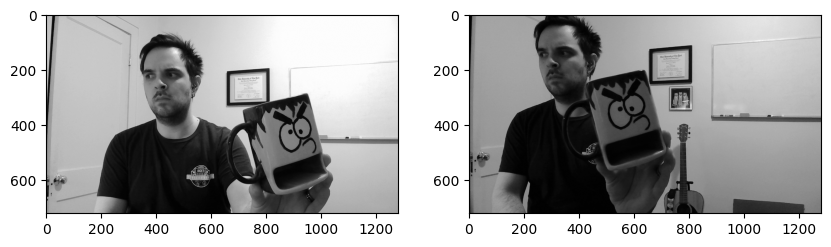

In [50]:
import cv2 as cv

img_idx = 2
FOLDER = "data/stereo"
img_l = cv.imread(f"{FOLDER}/left_{img_idx}.jpg")
img_l = cv.cvtColor(img_l, cv.COLOR_BGR2GRAY)
img_r = cv.imread(f"{FOLDER}/right_{img_idx}.jpg")
img_r = cv.cvtColor(img_r, cv.COLOR_BGR2GRAY)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img_l, 'gray')
ax[1].imshow(img_r, 'gray')
plt.show()

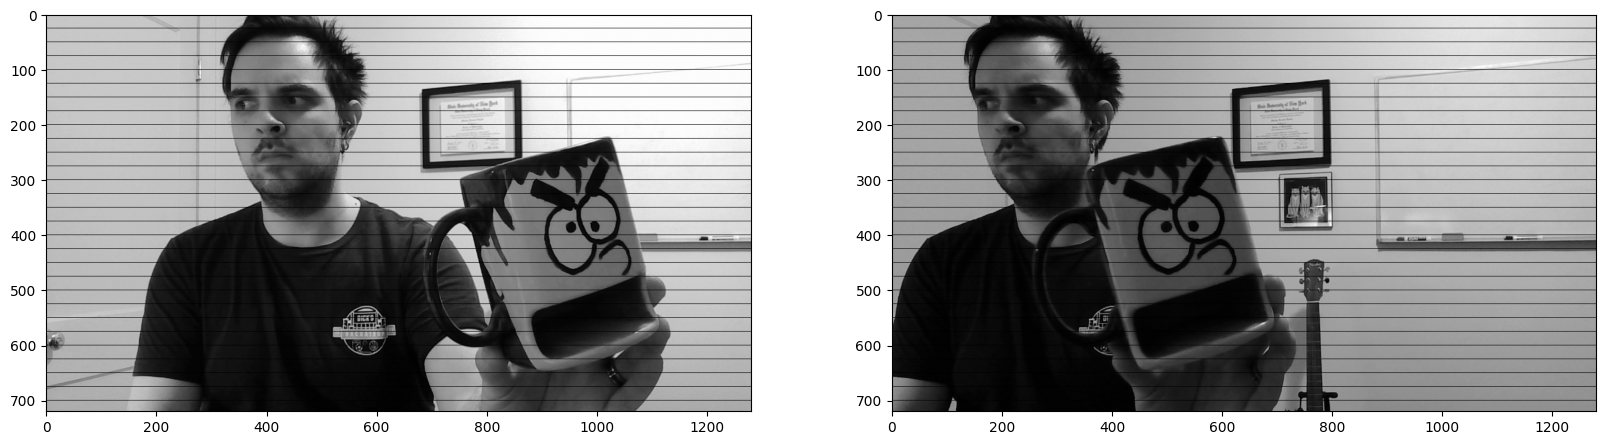

In [51]:
img_size = (img_l.shape[1], img_l.shape[0])

# Compute rectification transforms
R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(
    cameraMatrix1, distCoeffs1,
    cameraMatrix2, distCoeffs2,
    img_size,
    R, T,
    flags=cv.CALIB_ZERO_DISPARITY,
    alpha=0,    # 0 = zoomed in,  1 = keep all pixels 
)

# Compute undistort and rectify maps
left_map1, left_map2 = cv.initUndistortRectifyMap(
    cameraMatrix1, distCoeffs1, R1, P1, img_size, cv.CV_16SC2
)
right_map1, right_map2 = cv.initUndistortRectifyMap(
    cameraMatrix2, distCoeffs2, R2, P2, img_size, cv.CV_16SC2
)

# Remap (warp) images
rect_l = cv.remap(img_l, left_map1, left_map2, interpolation=cv.INTER_LINEAR)
rect_r = cv.remap(img_r, right_map1, right_map2, interpolation=cv.INTER_LINEAR)


# Display the rectified image pair
def draw_lines(img, step=25):
    for y in range(0, img.shape[0], step):
        cv.line(img, (0, y), (img.shape[1], y), (0, 255, 0), 1)

draw_lines(rect_l)
draw_lines(rect_r)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(rect_l, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(rect_r, cmap='gray')

Since my cameras are basically next to one another and not rotated, the epipolar lines are already nearly horizontal, and so the rectified images here look nearly identical to the original images.

## Next: try disparity map

With our image pair rectified, corresponding points lie on the same horizontal scanline.

We can compute a disparity map by taking each pixel in the left (reference) image, then search along the same row in the right image to try to find the matching pixel. We can find some candidate pixels and choose the one with the best matching score, then label the disparity for that pixel as the horizontal shift.

Since a large horizontal shift corresponds to objects in the foreground, it makes sense that there is a connection between disparity and depth.

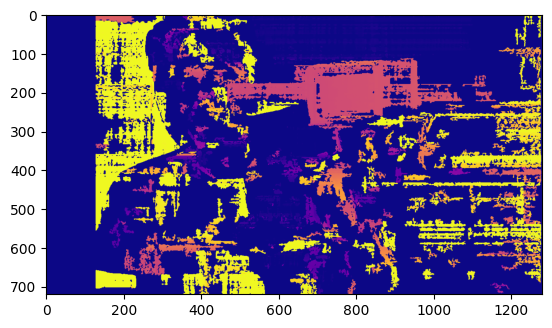

In [62]:
# Remap (warp) images again so that they are clean (no lines)
rect_l = cv.remap(img_l, left_map1, left_map2, interpolation=cv.INTER_LINEAR)
rect_r = cv.remap(img_r, right_map1, right_map2, interpolation=cv.INTER_LINEAR)

# 
window_size = 5 # block size
stereo = cv.StereoSGBM_create(
    minDisparity=0,
    numDisparities=2*64,  # must be divisible by 16
    blockSize=window_size,    # tweak for quality/performance
    P1=8 * 3 * window_size ** 2,
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=200,
    speckleRange=32,
    preFilterCap=63,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY,
)

# Compute the disparity map
disparity = stereo.compute(rect_l, rect_r).astype(np.float32) / 16.0

# Optional: mask invalid disparity values
disparity[disparity < 0] = 0

# Visualize
plt.imshow(disparity, 'plasma')
plt.show()

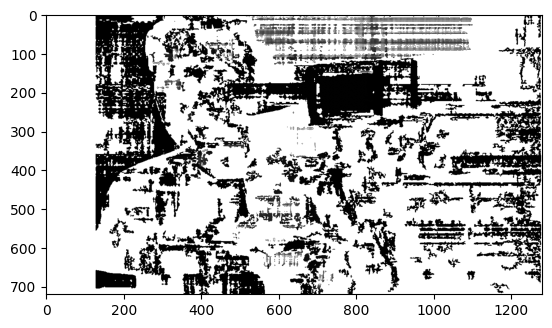

In [64]:
points_3d = cv.reprojectImageTo3D(disparity, Q)
depth_map = points_3d[:, :, 2]

plt.imshow(depth_map, cmap='gray')